# Tutorial 3: Evaluating the trained model on the test data

### Outline

* Imports, including library code from previous steps
* Loading the trained model using hyperparameters and weights file
* Setting up the datapipe for the test data
* Some functions for "undoing/inverting" the ETL pipeline (aka recovering spatiotemporal relations)
* Running the trained model in eval mode
* Some basic metrics and analysis

In [1]:
import torch
import xarray as xr
import matplotlib.pyplot as plt
import warnings

from tqdm.autonotebook import tqdm
from src.models import create_lstm_model
from src.utils import load_experiment
from src.datapipes import make_data_pipeline, merge_data, select_region

warnings.filterwarnings('ignore')
DEVICE = torch.device('cpu')
DTYPE = torch.float32

## Loading the setup from our saved experiment

In [2]:
config_file = '../experiments/tutorial/tutorial.yml'
config = load_experiment(config_file)
model = create_lstm_model(**config['model_config'])
model.load_state_dict(torch.load(config['weights_file']))
model.to(DEVICE)
model.eval()

Sequential(
  (0): LSTM(5, 128, batch_first=True)
  (1): LSTMOutput()
  (2): Linear(in_features=128, out_features=1, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
)

## Data plumbing for model inference

In [3]:
ds = merge_data()
test_data = select_region(
    ds.sel(time=config['data_config']['test_period']),
    config['data_config']['regions']
)

In [4]:
true_mask = test_data['mask'].copy()
test_data = test_data.fillna(1.0)
test_data['mask'].values[:] = 1.0
test_data = test_data.fillna(1.0)

In [5]:
actual_shape = (
    len(test_data['lat']),
    len(test_data['lon']),
    config['data_config']['output_sequence_length']
)
        

In [6]:
config['data_config']['batch_dims'] = {
    'lat': len(test_data['lat']),
    'lon': len(test_data['lon'])
}

In [7]:
pipe = make_data_pipeline(
    ds=test_data, 
    min_samples=0, 
    preload=True,
    filter_mask=False,
    **config['data_config']
)

## Running the model in forward/inference mode

In [8]:
predictions = []
for i, (x, y) in tqdm(enumerate(pipe)):
    x = x.to(DEVICE)
    with torch.no_grad():
        yhat = model(x).cpu()
    yhat = yhat.reshape(actual_shape)
    predictions.append(yhat)

0it [00:00, ?it/s]

## Putting the data back together

In [10]:
start_time = config['data_config']['input_overlap']['time'] 
swe_true = test_data['swe'].isel(time=slice(start_time, -7))

swe_pred = xr.DataArray(
    torch.concat(predictions, dim=2).squeeze().cpu(),
    dims=('lat', 'lon', 'time'), coords = swe_true.coords
) 

In [12]:
swe_pred

<xarray.DataArray (lat: 65, lon: 100, time: 2220)>
array([[[ 2.02695206e-02,  1.63023844e-02,  1.76608413e-02, ...,
          1.89933181e-02,  1.65911242e-02,  1.87937021e-02],
        [ 2.04451829e-02,  1.63108818e-02,  1.74735337e-02, ...,
          1.91583447e-02,  1.64758526e-02,  1.88418552e-02],
        [ 2.06490867e-02,  1.61902122e-02,  1.73326582e-02, ...,
          1.92581266e-02,  1.62209980e-02,  1.87063739e-02],
        ...,
        [-1.87037514e-07,  7.54734501e-05,  6.89212233e-04, ...,
          8.81736819e-03,  1.06068170e-02,  1.10757062e-02],
        [ 3.25404108e-05,  1.87523663e-04,  7.11044297e-04, ...,
          1.04614077e-02,  1.21704629e-02,  1.25709390e-02],
        [-2.42592751e-06, -1.72927969e-06,  3.83604318e-04, ...,
          1.02406470e-02,  1.19575011e-02,  1.23690749e-02]],

       [[ 1.98948346e-02,  1.65851042e-02,  1.74867921e-02, ...,
          1.87973008e-02,  1.64544471e-02,  1.80362388e-02],
        [ 2.00016797e-02,  1.65354982e-02,  1.73176825e-02, ...,
          1.88702568e-02,  1.64324716e-02,  1.82502829e-02],
        [ 2.00285725e-02,  1.64570920e-02,  1.70712806e-02, ...,
          1.89046934e-02,  1.62171647e-02,  1.82751045e-02],
...
         -5.40609471e-05, -5.82085413e-05, -5.15237807e-05],
        [-3.80667152e-05, -3.55993106e-05, -3.58361140e-05, ...,
         -5.17905173e-05, -5.58487118e-05, -5.18283996e-05],
        [-3.45105036e-05, -3.26768895e-05, -3.43983520e-05, ...,
         -4.98541558e-05, -5.54747494e-05, -5.46957672e-05]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-4.80065937e-05, -4.37915187e-05, -4.33755886e-05, ...,
         -5.57604289e-05, -5.86151873e-05, -5.17750050e-05],
        [-3.81032987e-05, -3.59833284e-05, -3.85957792e-05, ...,
         -5.13109444e-05, -5.59404652e-05, -5.19568275e-05],
        [-3.65778578e-05, -3.53917858e-05, -3.90710811e-05, ...,
         -4.84613192e-05, -5.58562460e-05, -5.63586036e-05]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 34.75 34.5 34.25 34.0
  * lon      (lon) float32 230.2 230.5 230.8 231.0 ... 254.2 254.5 254.8 255.0
  * time     (time) datetime64[ns] 2008-11-26 2008-11-27 ... 2014-12-24

In [20]:
test_data

<xarray.Dataset>
Dimensions:        (time: 2557, lat: 65, lon: 100)
Coordinates:
  * lat            (lat) float32 50.0 49.75 49.5 49.25 ... 34.75 34.5 34.25 34.0
  * lon            (lon) float32 230.2 230.5 230.8 231.0 ... 254.5 254.8 255.0
  * time           (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2014-12-31
Data variables: (12/19)
    pr             (time, lat, lon) float64 dask.array<chunksize=(366, 65, 100), meta=np.ndarray>
    ps             (time, lat, lon) float32 dask.array<chunksize=(366, 65, 100), meta=np.ndarray>
    psl            (time, lat, lon) float32 dask.array<chunksize=(366, 65, 100), meta=np.ndarray>
    rsds           (time, lat, lon) float64 dask.array<chunksize=(366, 65, 100), meta=np.ndarray>
    tas            (time, lat, lon) float32 dask.array<chunksize=(366, 65, 100), meta=np.ndarray>
    tasmax         (time, lat, lon) float32 dask.array<chunksize=(366, 65, 100), meta=np.ndarray>
    ...             ...
    swe            (time, lat, lon) float32 dask.array<chunksize=(46, 22, 100), meta=np.ndarray>
    mask           (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    aspect_cosine  (lat, lon) float64 1.0 1.0 1.0 ... -0.09664 -0.1322 -0.2063
    aspect_sine    (lat, lon) float64 1.0 1.0 1.0 1.0 ... 0.3945 0.4329 0.4137
    elevation      (lat, lon) float64 1.0 1.0 1.0 ... 1.71e+03 1.531e+03
    slope          (lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.652 1.447 1.328
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

## Getting to the analysis and quantifying model performance

Text(0.5, 1.0, 'Southern Rockies')

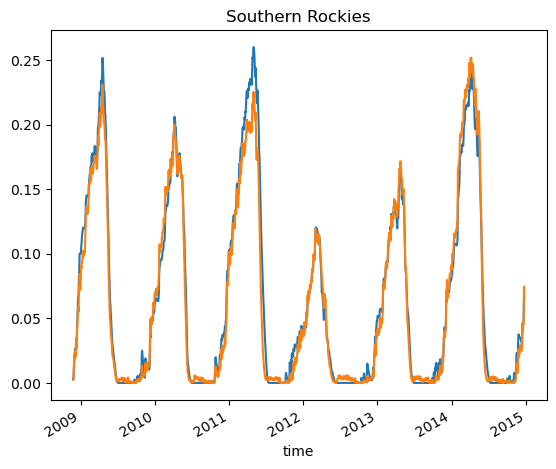

In [29]:
loc = {'lat': slice(40, 38), 'lon': slice(252, 254), }# 'method': 'nearest'}
swe_true.sel(**loc).mean(dim=['lat', 'lon']).plot()
(3 * swe_pred).sel(**loc).mean(dim=['lat', 'lon']).plot()
plt.title('Southern Rockies')

Text(0.5, 1.0, 'Northern Cascades')

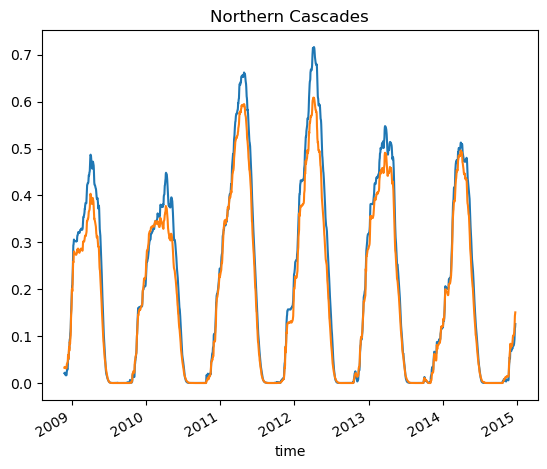

In [30]:
loc = {'lat': slice(49, 47), 'lon': slice(238, 240), }# 'method': 'nearest'}
swe_true.sel(**loc).mean(dim=['lat', 'lon']).plot()
(3 * swe_pred).sel(**loc).mean(dim=['lat', 'lon']).plot()
plt.title('Northern Cascades')

Text(0.5, 1.0, 'Central Sierra Nevada')

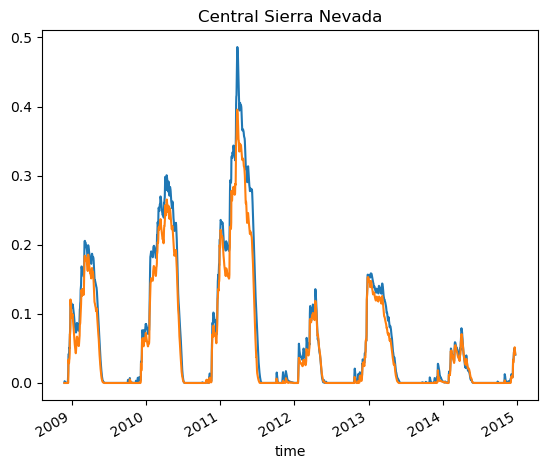

In [38]:
loc = {'lat': slice(38.5, 37.5), 'lon': slice(239.75, 240.25), }# 'method': 'nearest'}
swe_true.sel(**loc).mean(dim=['lat', 'lon']).plot()
(3 * swe_pred).sel(**loc).mean(dim=['lat', 'lon']).plot()
plt.title('Central Sierra Nevada')

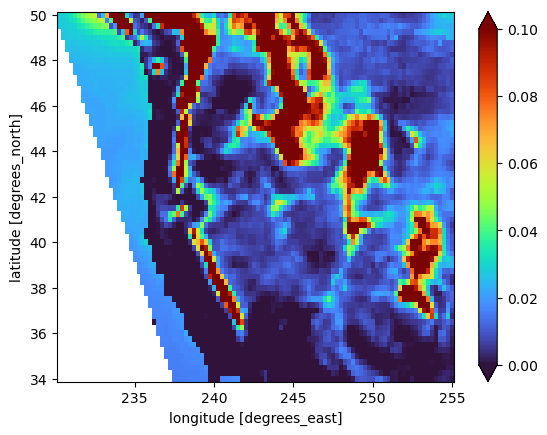

In [35]:
swe_pred.isel(time=slice(120, 400)).max(dim='time').plot(vmax=0.1, vmin=0, cmap='turbo')

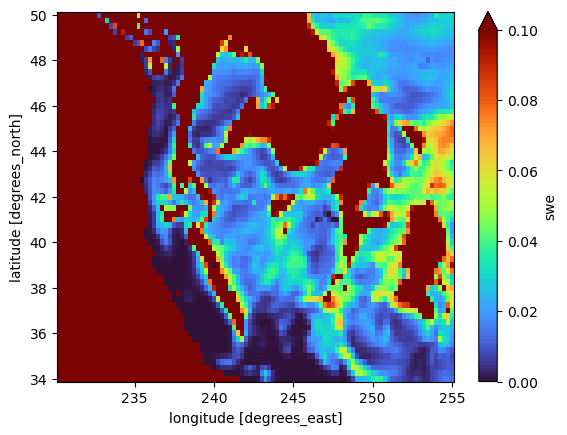

In [36]:
swe_true.isel(time=slice(120, 400)).max(dim='time').plot(vmax=0.1, vmin=0, cmap='turbo')

In [45]:
import numpy as np

In [9]:
pp = 3 * swe_pred.where(true_mask, other=np.nan).values.flatten()
pp = pp[np.isfinite(pp)]

plt.hist(pp, bins=100, density=True);
#plt.semilogy()

NameError: name 'swe_pred' is not defined

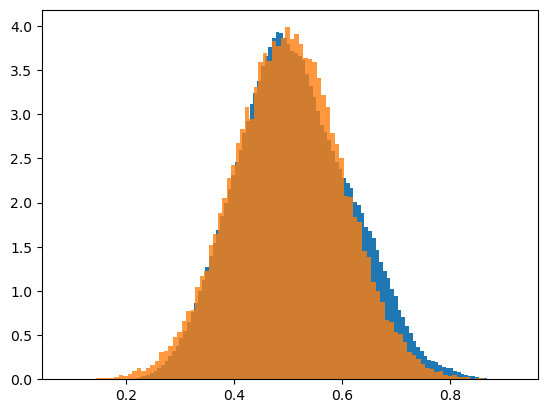

In [92]:
pp = 3 * swe_pred.where(true_mask, other=np.nan).values.flatten()
pp = pp[np.isfinite(pp)]

plt.hist(np.log(1.2 + np.power(pp, 1/4)), bins=100, density=True);
#plt.semilogy()

# pp = swe_true.where(true_mask, other=np.nan).values.flatten()
# pp = pp[np.isfinite(pp)]
# 
# plt.hist(np.power(pp, 1/3), bins=100, alpha=0.6);
#plt.semilogy()

plt.hist(np.random.normal(loc=0.5, scale=0.1, size=50000), bins=100, alpha=0.8, density=True);


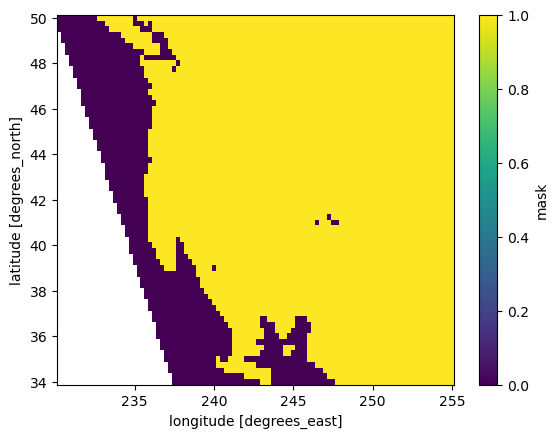

In [43]:
true_mask.plot()

In [39]:
swe_pred

<xarray.DataArray (lat: 65, lon: 100, time: 2220)>
array([[[ 2.02695206e-02,  1.63023844e-02,  1.76608413e-02, ...,
          1.89933181e-02,  1.65911242e-02,  1.87937021e-02],
        [ 2.04451829e-02,  1.63108818e-02,  1.74735337e-02, ...,
          1.91583447e-02,  1.64758526e-02,  1.88418552e-02],
        [ 2.06490867e-02,  1.61902122e-02,  1.73326582e-02, ...,
          1.92581266e-02,  1.62209980e-02,  1.87063739e-02],
        ...,
        [-1.87037514e-07,  7.54734501e-05,  6.89212233e-04, ...,
          8.81736819e-03,  1.06068170e-02,  1.10757062e-02],
        [ 3.25404108e-05,  1.87523663e-04,  7.11044297e-04, ...,
          1.04614077e-02,  1.21704629e-02,  1.25709390e-02],
        [-2.42592751e-06, -1.72927969e-06,  3.83604318e-04, ...,
          1.02406470e-02,  1.19575011e-02,  1.23690749e-02]],

       [[ 1.98948346e-02,  1.65851042e-02,  1.74867921e-02, ...,
          1.87973008e-02,  1.64544471e-02,  1.80362388e-02],
        [ 2.00016797e-02,  1.65354982e-02,  1.73176825e-02, ...,
          1.88702568e-02,  1.64324716e-02,  1.82502829e-02],
        [ 2.00285725e-02,  1.64570920e-02,  1.70712806e-02, ...,
          1.89046934e-02,  1.62171647e-02,  1.82751045e-02],
...
         -5.40609471e-05, -5.82085413e-05, -5.15237807e-05],
        [-3.80667152e-05, -3.55993106e-05, -3.58361140e-05, ...,
         -5.17905173e-05, -5.58487118e-05, -5.18283996e-05],
        [-3.45105036e-05, -3.26768895e-05, -3.43983520e-05, ...,
         -4.98541558e-05, -5.54747494e-05, -5.46957672e-05]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-4.80065937e-05, -4.37915187e-05, -4.33755886e-05, ...,
         -5.57604289e-05, -5.86151873e-05, -5.17750050e-05],
        [-3.81032987e-05, -3.59833284e-05, -3.85957792e-05, ...,
         -5.13109444e-05, -5.59404652e-05, -5.19568275e-05],
        [-3.65778578e-05, -3.53917858e-05, -3.90710811e-05, ...,
         -4.84613192e-05, -5.58562460e-05, -5.63586036e-05]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 34.75 34.5 34.25 34.0
  * lon      (lon) float32 230.2 230.5 230.8 231.0 ... 254.2 254.5 254.8 255.0
  * time     (time) datetime64[ns] 2008-11-26 2008-11-27 ... 2014-12-24